# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Read Hydro Energy Production Dataset

In [2]:
data = pd.read_csv('F:\APU\FYP\Dataset\Cleaned_data\hydro_production_dataset.csv')

data.head()

,Country,Date,Value,Precipitation
0,Australia,2023-03-01,1215.8041,0.080641
1,Australia,2023-02-01,942.5558,0.127869
2,Australia,2023-01-01,1190.7296,0.159242
3,Australia,2022-12-01,1110.1523,0.105662
4,Australia,2022-11-01,1397.5839,0.073524


## Extract Data for each country

In [3]:
countries = data['Country'].unique()

hydro_production_data = {}

# use loc() function to select data from a DataFrame based on specified row and column labels or conditions.
# Iterate over the countries
for country in countries:
    # Filter the data for the current country and 'Hydro' product
    country_energy_production = data.loc[
        (data['Country'] == country), ['Date', 'Value', 'Precipitation']
    ]
    
    # Store the filtered data in the dictionary
    hydro_production_data[country] = country_energy_production.reset_index(drop=True)

hydro_production_data['Brazil']

,Date,Value,Precipitation
0,2023-03-01,42125.0402,0.311849
1,2023-02-01,37537.4705,0.309499
2,2023-01-01,40131.3684,0.310632
3,2022-12-01,37731.9933,0.301121
4,2022-11-01,33992.2079,0.225746
...,...,...,...
94,2015-05-01,28657.9530,0.210786
95,2015-04-01,29569.5100,0.263281
96,2015-03-01,32357.8210,0.344330
97,2015-02-01,30085.6360,0.319078


# Resample to daily data

In [4]:
# hypro_production_data
for country_data in hydro_production_data:
    
    # set time as the index
    hydro_production_data[country_data]['Date'] = pd.to_datetime(hydro_production_data[country_data]['Date'])
    hydro_production_data[country_data].set_index('Date', inplace=True)
    
    # divide the monthly statistical production value by the number of days 
    # of the month to get the avarage daily production value
    hydro_production_data[country_data]['Value'] = (hydro_production_data[country_data]['Value']/
                                                    hydro_production_data[country_data].index.days_in_month)
    
    # resample the monthly index to daily and impute the missing value with linear interpolate method
    daily_data = hydro_production_data[country_data].resample('D').interpolate('linear')
    hydro_production_data[country_data] = daily_data
    
hydro_production_data['Brazil']

,Value,Precipitation
Date,,
2015-01-01,1107.850774,0.248368
2015-01-02,1106.774523,0.250649
2015-01-03,1105.698273,0.252930
2015-01-04,1104.622022,0.255211
2015-01-05,1103.545771,0.257492
...,...,...
2023-02-25,1356.265362,0.311514
2023-02-26,1356.917088,0.311598
2023-02-27,1357.568813,0.311681


## Split Train and Test Data

In [5]:
data = hydro_production_data['Brazil']

# Split the data into training and testing sets
split_date = '2021-01-01'
train, test = data[:split_date][['Value']], data[split_date:][['Value']]

print(train.head())
print(train.shape)
print()
print(test.head())
print(test.shape)

                  Value
Date                   
2015-01-01  1107.850774
2015-01-02  1106.774523
2015-01-03  1105.698273
2015-01-04  1104.622022
2015-01-05  1103.545771
(2193, 1)

                  Value
Date                   
2021-01-01  1081.207087
2021-01-02  1085.324484
2021-01-03  1089.441881
2021-01-04  1093.559278
2021-01-05  1097.676675
(790, 1)


# Univaraite - ARIMA

#### The developer has use R with the auto.arima() function to identify the p, q, d value of the best fit ARIMA model for this dataset, the result shows that the order(p, q, d) = (1,1,0)(0,1,0)[365] 
#### Figure below show the result from R:
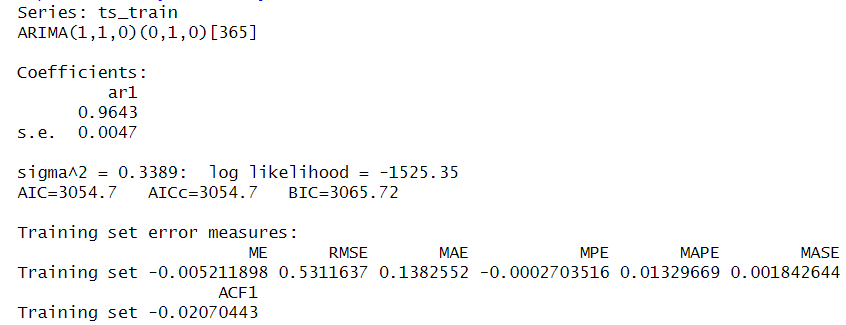

In [73]:
import rpy2.robjects as robjects
# Load the 'forecast' R package
robjects.r("library(forecast)")

# Load the ARIMA model
r_load = robjects.r['readRDS']
brz_hydro_arima_model = r_load(r"F:\APU\FYP\SEM 2\Report Doc\R script\brz_hydro_arima_model.rds")

In [74]:
# Generate predictions
r_forecast = robjects.r['forecast']
predictions = r_forecast(brz_hydro_arima_model, h=len(test))

# Evaluate the model performance
print("Mean Absolute Error: ", mean_absolute_error(predictions.rx('mean')[0], test.values))
mse = mean_squared_error(predictions.rx('mean')[0], test.values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", math.sqrt(mse))

Mean Absolute Error:  312.4786935669045
Mean Squared Error:  132661.4110553219
Root Mean Squared Error:  364.22714211782994


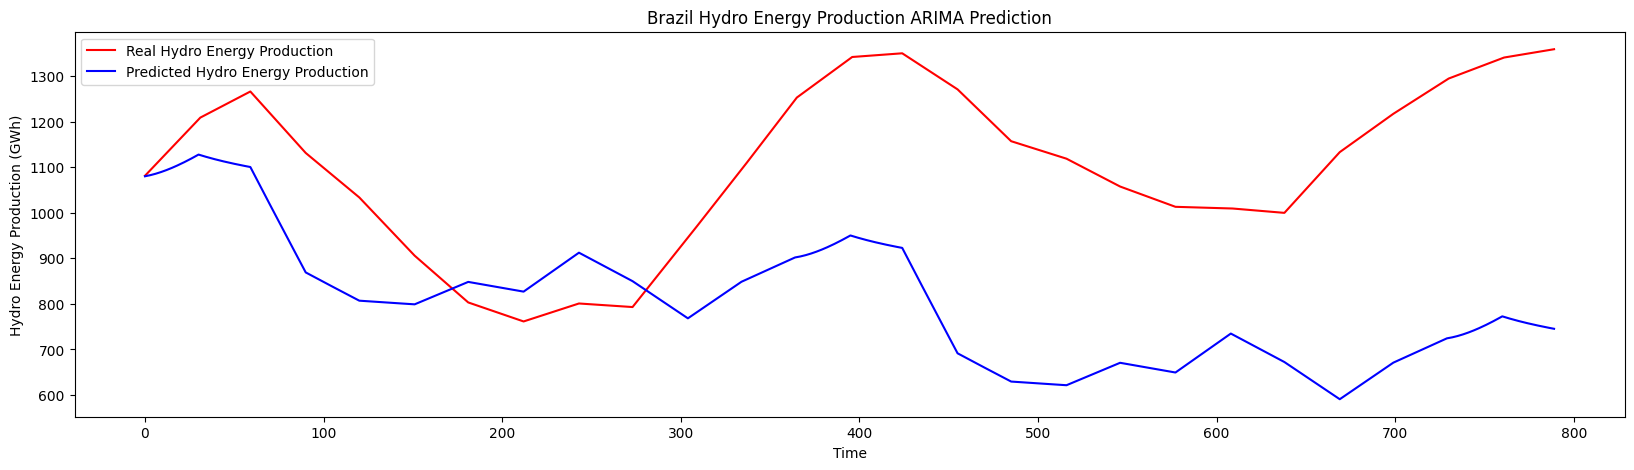

In [75]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test.values, color = 'red', label = 'Real Hydro Energy Production')
plt.plot(predictions.rx('mean')[0], color = 'blue', label = 'Predicted Hydro Energy Production')
plt.title('Brazil Hydro Energy Production ARIMA Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy Production (GWh)')
plt.legend()
plt.show()

## Univariate - SVR - Daily

In [6]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [76]:
# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['Value']].values)
test_scaled = scaler.transform(test[['Value']].values)

# Reshape the input data to fit
time_steps = 365  # Define the number of previous time steps to consider

# Creating a data structure with 365 timestamps and 1 output
x_train = []
y_train = []
for i in range(time_steps, len(train)):
    x_train.append(train_scaled[i-time_steps:i, 0])
    y_train.append(train_scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train.shape, y_train.shape)

(1828, 365) (1828,)


In [77]:
# Build and Train the SVM Model
brz_daily_svr = SVR(kernel='linear',gamma=0.5, C=10, epsilon = 0.01)
brz_daily_svr.fit(x_train, y_train)

SVR(C=10, epsilon=0.01, gamma=0.5, kernel='linear')

In [78]:
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
x_test = []
for i in range(time_steps, len(test)+time_steps):
    x_test.append(inputs[i-time_steps:i, 0])
x_test = np.array(x_test)

# Predict Hydro Energy Production
svr_y_pred = brz_daily_svr.predict(x_test).reshape(-1,1)
svr_y_pred = scaler.inverse_transform(svr_y_pred)
print(svr_y_pred.shape)

(790, 1)


In [79]:
# Evaluate the model
print("Mean Absolute Error: ", mean_absolute_error(svr_y_pred, test['Value'].values))
mse = mean_squared_error(svr_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  3.673266300848552
Mean Squared Error:  21.16135420335652
Root Mean Squared Error:  4.600147193662016


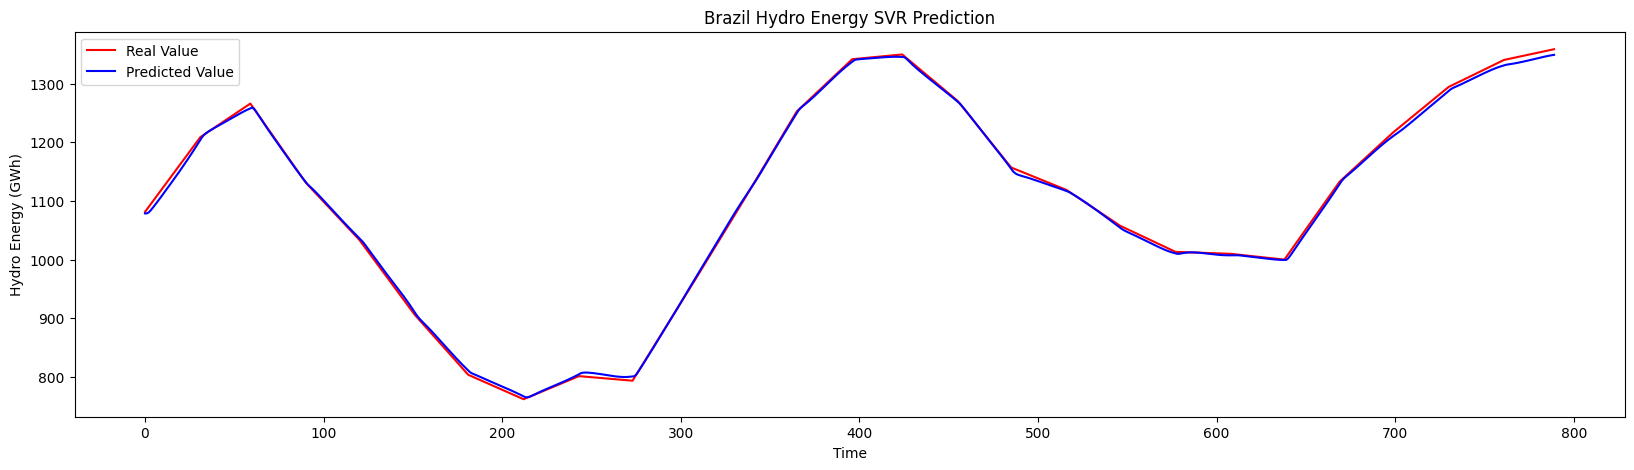

In [80]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color='red', label='Real Value')
plt.plot(svr_y_pred, color='blue', label='Predicted Value')
plt.title('Brazil Hydro Energy SVR Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy (GWh)')
plt.legend()
plt.show()

## Univariate ANN - Daily

In [46]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train.values)

In [13]:
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# Set the number of time steps (input sequence length)
time_steps = 365

# Create the training datasets
X_train, y_train = create_dataset(training_set_scaled, time_steps)

# Create the testing datasets
X_test, y_test = create_dataset(test.values, time_steps)

X_train.shape

(1828, 365, 1)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import Dropout

# Create the model
brz_daily_ann = Sequential()
brz_daily_ann.add(Dense(84, activation='tanh', input_shape=(365,)))
brz_daily_ann.add(Dropout(0.2))
brz_daily_ann.add(Dense(1, activation='linear'))

brz_daily_ann.compile(optimizer='adam', loss='mean_squared_error')

brz_daily_ann.fit(X_train, y_train, epochs=100, batch_size=16)

Epoch 1/100
115/115 [==============================] - 8s 3ms/step - loss: 0.1459
Epoch 2/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0416
Epoch 3/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0191
Epoch 4/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 5/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 6/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 7/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 8/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0104
Epoch 9/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 10/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 11/100
115/115 [==============================] - 0s 4ms/step - loss: 0.0055
Epoch 12/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 13/100


In [47]:
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(time_steps, len(test)+time_steps):
    X_test.append(inputs[i-time_steps:i])
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

ann_y_pred = brz_daily_ann.predict(X_test)
ann_y_pred = sc.inverse_transform(ann_y_pred)

print("Mean Absolute Error: ", mean_absolute_error(ann_y_pred, test.values))
mse = mean_squared_error(ann_y_pred, test.values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

25/25 [==============================] - 4s 24ms/step
Mean Absolute Error:  14.444807732008401
Mean Squared Error:  340.81026826678993
Root Mean Squared Error:  18.4610473231285


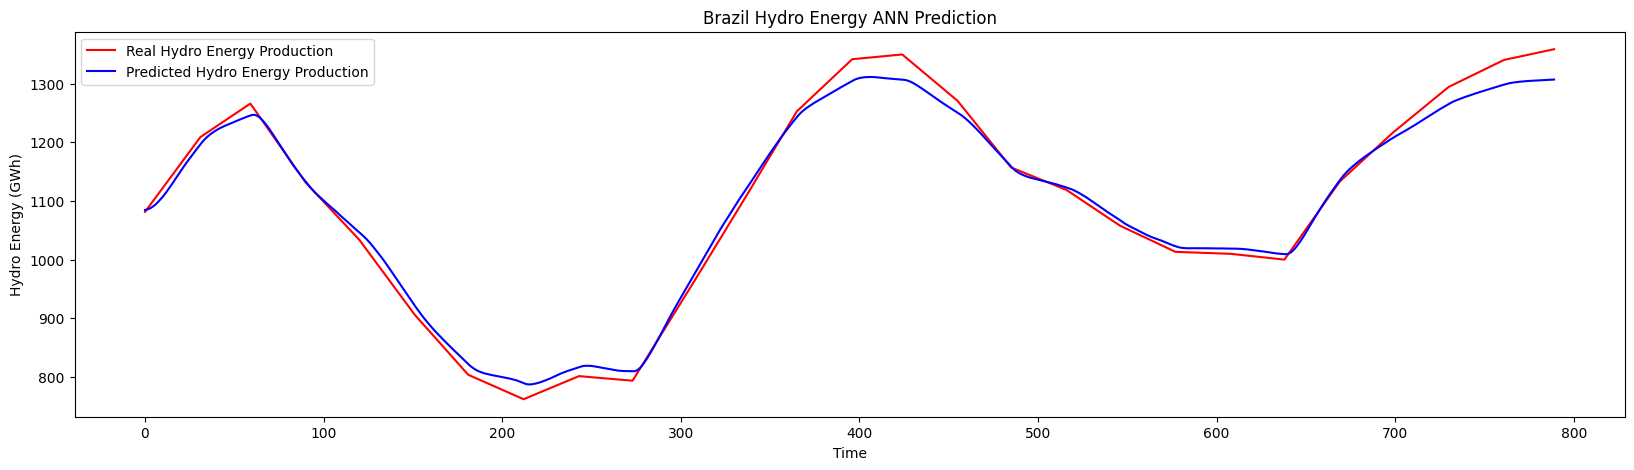

In [48]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test.values, color = 'red', label = 'Real Hydro Energy Production')
plt.plot(ann_y_pred, color = 'blue', label = 'Predicted Hydro Energy Production')
plt.title('Brazil Hydro Energy ANN Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy (GWh)')
plt.legend()
plt.show()

## Univariate LSTM - Daily

In [49]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train.values)

print(training_set_scaled)
print(training_set_scaled.shape)

[[0.55071165]
 [0.54852652]
 [0.54634139]
 ...
 [0.4893988 ]
 [0.49300771]
 [0.49661662]]
(2193, 1)


In [18]:
# Creating a data structure with 365 timestamps and 1 output
X_train = []
y_train = []
for i in range(time_steps, len(train)):
    X_train.append(training_set_scaled[i-365:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [19]:
print(X_train)
X_train.shape

[[0.55071165 0.54852652 0.54634139 ... 0.45864168 0.46322324 0.4678048 ]
 [0.54852652 0.54634139 0.54415627 ... 0.46322324 0.4678048  0.47238636]
 [0.54634139 0.54415627 0.54197114 ... 0.4678048  0.47238636 0.4760173 ]
 ...
 [0.71336441 0.7218354  0.72786224 ... 0.47857208 0.48218099 0.4857899 ]
 [0.7218354  0.72786224 0.73388909 ... 0.48218099 0.4857899  0.4893988 ]
 [0.72786224 0.73388909 0.73991593 ... 0.4857899  0.4893988  0.49300771]]


(1828, 365)

In [20]:
print(y_train)
y_train.shape

[0.47238636 0.4760173  0.47964825 ... 0.4893988  0.49300771 0.49661662]


(1828,)

In [21]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [22]:
# Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [23]:
# Initialising the RNN
brz_daily_uni_lstm = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
brz_daily_uni_lstm.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], 1)))
brz_daily_uni_lstm.add(Dropout(0.2))

brz_daily_uni_lstm.add(LSTM(units = 64, return_sequences = True))
brz_daily_uni_lstm.add(Dropout(0.2))

brz_daily_uni_lstm.add(LSTM(units = 64))
brz_daily_uni_lstm.add(Dropout(0.2))

# Adding the output layer
brz_daily_uni_lstm.add(Dense(units = 1))

In [24]:
# Compiling the RNN
brz_daily_uni_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
brz_daily_uni_lstm.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
58/58 [==============================] - 110s 665ms/step - loss: 0.0181
Epoch 2/100
58/58 [==============================] - 38s 657ms/step - loss: 0.0038
Epoch 3/100
58/58 [==============================] - 41s 704ms/step - loss: 0.0031
Epoch 4/100
58/58 [==============================] - 39s 667ms/step - loss: 0.0025
Epoch 5/100
58/58 [==============================] - 41s 704ms/step - loss: 0.0023
Epoch 6/100
58/58 [==============================] - 37s 639ms/step - loss: 0.0023
Epoch 7/100
58/58 [==============================] - 38s 660ms/step - loss: 0.0022
Epoch 8/100
58/58 [==============================] - 41s 707ms/step - loss: 0.0018
Epoch 9/100
58/58 [==============================] - 44s 757ms/step - loss: 0.0017
Epoch 10/100
58/58 [==============================] - 46s 793ms/step - loss: 0.0018
Epoch 11/100
58/58 [==============================] - 47s 819ms/step - loss: 0.0016
Epoch 12/100
58/58 [==============================] - 49s 848ms/step - loss: 0.0015


In [25]:
test[['Value']].shape

(790, 1)

In [50]:
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(time_steps, len(test)+time_steps):
    X_test.append(inputs[i-time_steps:i, 0])
    y_test.append(inputs[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
uni_lstm_y_pred = brz_daily_uni_lstm.predict(X_test)
uni_lstm_y_pred = sc.inverse_transform(uni_lstm_y_pred)

25/25 [==============================] - 10s 268ms/step


In [52]:
print("Mean Absolute Error: ", mean_absolute_error(uni_lstm_y_pred, test.values))
mse = mean_squared_error(uni_lstm_y_pred, test.values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  4.813887152765077
Mean Squared Error:  32.5550698389193
Root Mean Squared Error:  5.705705025579162


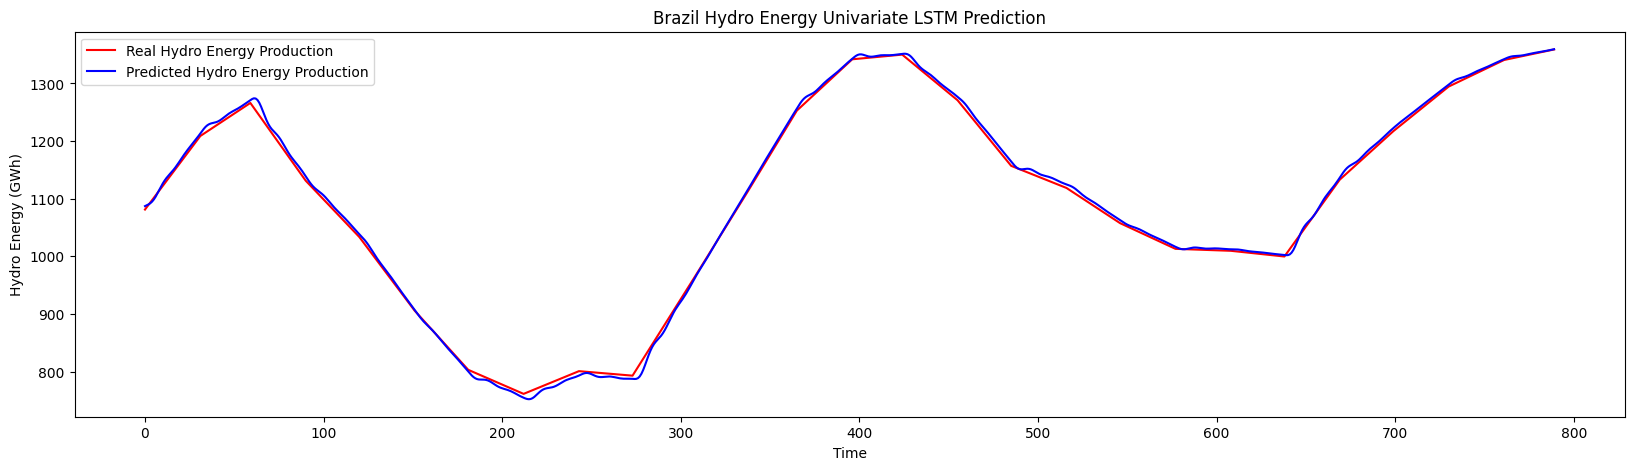

In [51]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test.values, color = 'red', label = 'Real Hydro Energy Production')
plt.plot(uni_lstm_y_pred, color = 'blue', label = 'Predicted Hydro Energy Production')
plt.title('Brazil Hydro Energy Univariate LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy (GWh)')
plt.legend()
plt.show()

## Multivariate LSTM

In [29]:
data = hydro_production_data['Brazil']

data.shape

(2982, 2)

In [53]:
X = data[['Precipitation', 'Value']]
y = data[['Value']]

X.head()

,Precipitation,Value
Date,,
2015-01-01,0.248368,1107.850774
2015-01-02,0.250649,1106.774523
2015-01-03,0.252930,1105.698273
2015-01-04,0.255211,1104.622022
2015-01-05,0.257492,1103.545771


In [54]:
# Split the data into training and testing sets
split_date = '2021-01-01'
X_train, X_test = X[:split_date], X[split_date:]
y_train, y_test = y[:split_date], y[split_date:]

In [55]:
# Scale the features and target variables using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
X_train, X_test = X_scaler.fit_transform(X_train), X_scaler.transform(X_test)
y_train, y_test = y_scaler.fit_transform(y_train), y_scaler.transform(y_test)

In [33]:
print(X_train.shape)
print(X_test.shape)
print()
print(y_train.shape)
print(y_test.shape)

(2193, 2)
(790, 2)

(2193, 1)
(790, 1)


In [34]:
# Reshape the input data to fit the LSTM model (samples, time steps, features)
time_steps = 365  # Define the number of previous time steps to consider
n_features = X_train.shape[1]  # Number of features

# Creating a data structure with 365 timestamps and 1 output
X_train1 = []
y_train1 = []
for i in range(time_steps, len(X_train)):
    X_train1.append(X_train[i-time_steps:i])
    y_train1.append(y_train[i][0])
X_train1, y_train1 = np.array(X_train1), np.array(y_train1)

X_train1 = np.reshape(X_train1, (X_train1.shape[0], X_train1.shape[1], X_train1.shape[2]))

print(X_train1.shape)

(1828, 365, 2)


In [35]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

brz_daily_multi_lstm = Sequential()
brz_daily_multi_lstm.add(LSTM(units = 64, return_sequences = True, input_shape=(time_steps, n_features)))
brz_daily_multi_lstm.add(Dropout(0.2))
brz_daily_multi_lstm.add(LSTM(units = 64, activation = 'relu', return_sequences = True))
brz_daily_multi_lstm.add(Dropout(0.2))
brz_daily_multi_lstm.add(LSTM(units = 64))
brz_daily_multi_lstm.add(Dropout(0.2))
brz_daily_multi_lstm.add(Dense(1))

In [36]:
brz_daily_multi_lstm.compile(optimizer='adam', loss='mean_squared_error')

brz_daily_multi_lstm.fit(X_train1, y_train1, epochs=100, batch_size=32)

Epoch 1/100
58/58 [==============================] - 119s 775ms/step - loss: 0.0208
Epoch 2/100
58/58 [==============================] - 49s 852ms/step - loss: 0.0046
Epoch 3/100
58/58 [==============================] - 45s 770ms/step - loss: 0.0034
Epoch 4/100
58/58 [==============================] - 44s 757ms/step - loss: 0.0026
Epoch 5/100
58/58 [==============================] - 46s 787ms/step - loss: 0.0025
Epoch 6/100
58/58 [==============================] - 45s 770ms/step - loss: 0.0023
Epoch 7/100
58/58 [==============================] - 41s 705ms/step - loss: 0.0023
Epoch 8/100
58/58 [==============================] - 40s 696ms/step - loss: 0.0026
Epoch 9/100
58/58 [==============================] - 48s 830ms/step - loss: 0.0020
Epoch 10/100
58/58 [==============================] - 52s 902ms/step - loss: 0.0024
Epoch 11/100
58/58 [==============================] - 52s 899ms/step - loss: 0.0024
Epoch 12/100
58/58 [==============================] - 54s 931ms/step - loss: 0.0018


58/58 [==============================] - 49s 840ms/step - loss: 4.9592e-04
Epoch 97/100
58/58 [==============================] - 58s 1s/step - loss: 6.7810e-04
Epoch 98/100
58/58 [==============================] - 55s 953ms/step - loss: 5.1749e-04
Epoch 99/100
58/58 [==============================] - 56s 966ms/step - loss: 5.5650e-04
Epoch 100/100
58/58 [==============================] - 55s 953ms/step - loss: 4.8280e-04


In [56]:
X_total_data = X
inputs = X_total_data[len(X_total_data) - len(X_test) - 365:]
inputs = X_scaler.transform(inputs)

X_test1 = []
for i in range(time_steps, len(X_test)+time_steps):
    X_test1.append(inputs[i-time_steps:i])
X_test1 = np.array(X_test1)
X_test1 = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], X_test1.shape[2]))

multi_lstm_y_pred = brz_daily_multi_lstm.predict(X_test1)
multi_lstm_y_pred = y_scaler.inverse_transform(multi_lstm_y_pred)
real_value = y_scaler.inverse_transform(y_test)

25/25 [==============================] - 9s 239ms/step


In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("Mean Absolute Error: ", mean_absolute_error(multi_lstm_y_pred, real_value))
mse = mean_squared_error(multi_lstm_y_pred, real_value)
print("Mean Squared Error: ", mse)
import math
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  7.077657602192497
Mean Squared Error:  104.2865977729261
Root Mean Squared Error:  10.212080971718061


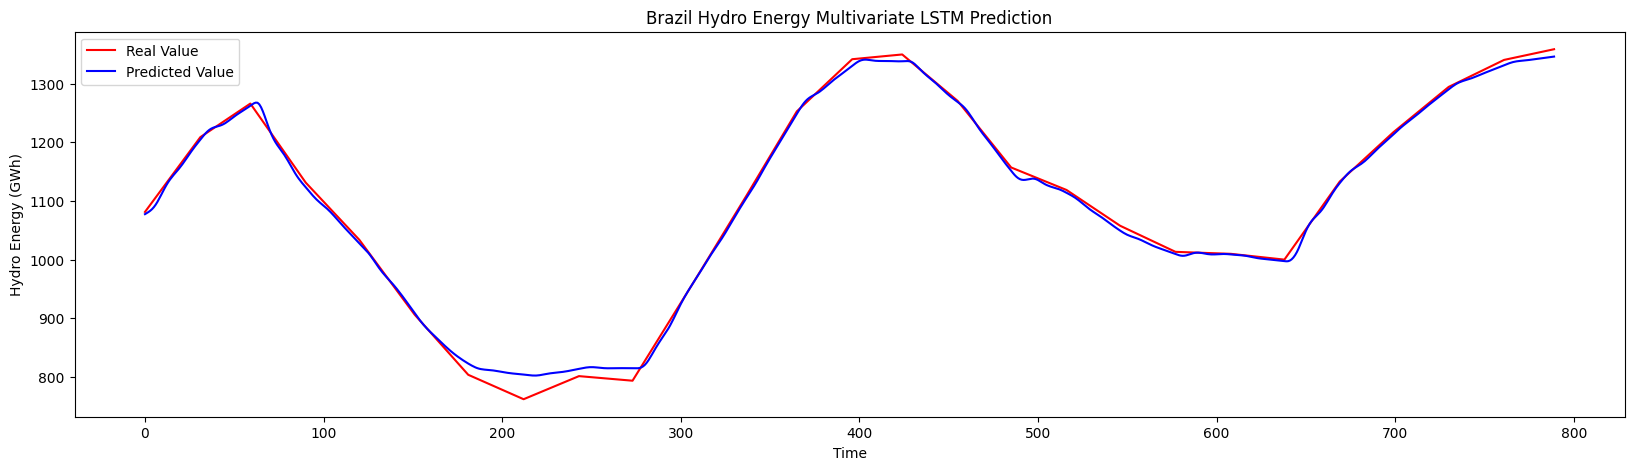

In [59]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(real_value, color='red', label='Real Value')
plt.plot(multi_lstm_y_pred, color='blue', label='Predicted Value')
plt.title('Brazil Hydro Energy Multivariate LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy (GWh)')
plt.legend()
plt.show()

# Overview

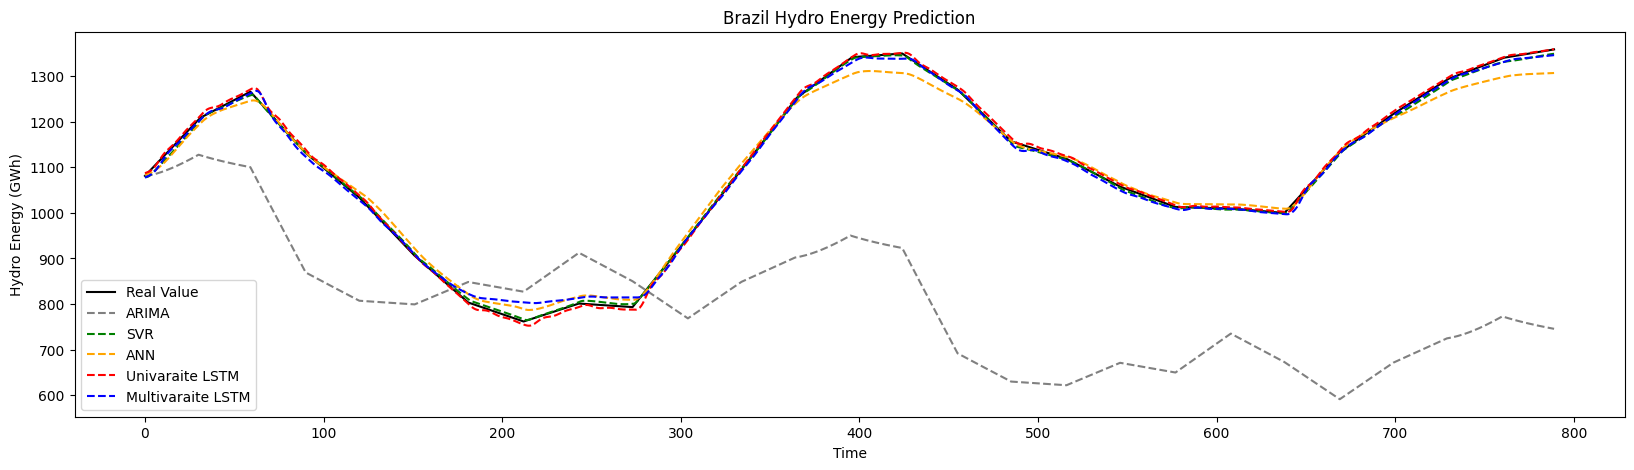

In [81]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(real_value, color='black', label='Real Value')
plt.plot(predictions.rx('mean')[0], color='grey', linestyle='--', label='ARIMA')
plt.plot(svr_y_pred, color='green', linestyle='--', label='SVR')
plt.plot(ann_y_pred, color='orange', linestyle='--', label='ANN')
plt.plot(uni_lstm_y_pred, color='red', linestyle='--', label='Univaraite LSTM')
plt.plot(multi_lstm_y_pred, color='blue', linestyle='--', label='Multivaraite LSTM')
plt.title('Brazil Hydro Energy Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy (GWh)')
plt.legend()
plt.show()

# Save Best Model

In [40]:
brz_daily_uni_lstm.save('brz_hydro_best_uni_lstm.h5')

C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
